In [1]:
# Packages
import math
from math import nan
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import h5py
import netCDF4
from datetime import datetime
from glob import glob
import shutil

In [3]:
# Functions and variables
def Ne_convert(e: float,P: float,T: float) -> float:
    """Convert electron concentration to density

    Args:
        e (float): Mixing ration
        P (float): Pressure
        T (float): Temperature

    Returns:
        float: Electron density
    """
    return e*P/(k*T)

def z(p):
    """Convert pressure to altitude

    Args:
        p (float): pressure (in hPa)

    Returns:
        float: altitude (in km)
    """
    return - 7 * np.log(p/1013.25)

def convert_utime(start_time: float, end_time: float):
    """Convert numpy.float65 to datetime.datetime 

    Args:
        start_time (float): Start time of the measured data
        end_time (float): End time of the measured data

    Returns:
        datetime,datetime: Date converted to datetime
    """
    start_time2, end_time2 = [], []
    if len(start_time) == len(end_time):
        for i in range(len(start_time)):
            start_time2.append(datetime.fromtimestamp(data['utime'][0][i]))
            end_time2.append(datetime.fromtimestamp(data['utime'][1][i]))
        return np.array(start_time2), np.array(end_time2)
    
def get_nrec(metadata,data):
    """Get nrec value from searching in metadata

    Args:
        metadata ([[String]]): Metadata array
        data ([[String]]): Data array
    Returns:
        int: number of height measurements 
    """
    i = 0
    for array in metadata:
        if array[0].strip() == b'nrec':
            return(data[i][0])
        i += 1

k = 1.38*10**(-23) # J/K

In [4]:
date = '2004-11-11'
folder_path = '../../DataSorted/' + date 
WACCM_path = folder_path + '/*.nc'
EISCAT_path = folder_path + '/*.hdf5'

WACCM_files = []
EISCAT_files = []

if len(glob(WACCM_path)) == 1:
    WACCM_files = [netCDF4.Dataset(glob(WACCM_path)[0])]
    print(str(len(glob(WACCM_path))) + ' WACCM data file found.')
elif len(glob(WACCM_path)) > 1:
    for file in glob(WACCM_path):
        WACCM_files.append(netCDF4.Dataset(glob(file)[0]))
    print(str(len(glob(WACCM_path))) + ' WACCM data files found.')
else:
    print('No WACCM data file found.')

if len(glob(EISCAT_path)) == 1:
    EISCAT_files = [h5py.File(glob(EISCAT_path)[0])]
    print(str(len(glob(EISCAT_path))) + ' EISCAT data file found.')
elif len(glob(EISCAT_path)) > 1:
    for file in glob(EISCAT_path):
        EISCAT_files.append(h5py.File(glob(file)[0]))
    print(str(len(glob(EISCAT_path))) + ' EISCAT data files found.')
else:
    print('No EISCAT data file found.') 

2 WACCM data files found.
2 EISCAT data files found.


In [5]:
lat = WACCM_files[0]['instr_lat'][:]
lon = WACCM_files[0]['instr_lon'][:]
num = WACCM_files[0]['instr_num'][:]
date = WACCM_files[0]['obs_date'][:]
time = WACCM_files[0]['obs_time'][:]
lev = WACCM_files[0]['lev'][:]
e = WACCM_files[0]['e'][:]
T = WACCM_files[0]['T'] [:]

i = 1
for file in WACCM_files[1:]:
    temp_lat = file['instr_lat'][:] # Latitude of the instrument
    temp_lon = file['instr_lon'][:] # Longitude of the instrument
    temp_num = file['instr_num'][:] # Numerical identifier of the instrument
    temp_date = file['obs_date'][:] # Observation date
    temp_time = file['obs_time'][:] # Observation time
    temp_e = file['e'][:] # Mixing ratio 
    temp_T = file['T'][:] # Temperature

    lat = np.concatenate((lat, temp_lat))
    lon = np.concatenate((lon, temp_lon))
    num = np.concatenate((num, temp_num))
    date = np.concatenate((date, temp_date))
    time = np.concatenate((time, temp_time))
    e = np.concatenate((e, temp_e))
    T = np.concatenate((T, temp_T))

EISCAT_file = EISCAT_files[0]

# Coordinate Restrictions for Tromso
mask_tromso = (lat > 69.5) & (lat < 69.7)
mask_svalbard = (lat > 78.8) & (lat < 79.0)

lev_mask = lev < 0.01
P = lev[lev_mask]
H = z(P)
NeWACCM = []
for array in e[mask_svalbard]:
    NeWACCM.append(array[lev_mask])

NeWACCM = np.array(NeWACCM)
hours = time[mask_svalbard]/3600

mask_hours = [hours[i] > hours[i+1] for i in range(len(hours)-1)]
indices = [i+1 for i, value in enumerate(mask_hours) if value]

print(indices)

for indice in indices:
    hours[indice:] = hours[indice:] + 24

# EISCAT data
data = EISCAT_file['data'] # Get data from the file
metadata = EISCAT_file['metadata'] # Get metadata from the file

nrec = get_nrec(metadata['par0d'][:],data['par0d'][:]) # Number of height measurements 
h = data['par2d'][0] # Altitude m
Ne = data['par2d'][2] # Electron density m-3
Ti = data['par2d'][3] # Ion temperature K
Te = data['par2d'][4] # Electron to ion temperature ratio
ve = data['par2d'][6] # Electron drift velocity 
Time = np.repeat(data['utime'][0], nrec) # Time value

start_date, end_date = convert_utime(data['utime'][0],data['utime'][1]) # Converted time value
mask = h <= 150000 # Create mask for < 200 km
Timebis = np.repeat(start_date, nrec) 
Time_hours_minutes = np.array([float(t.strftime('%H.%M')) for t in Timebis]) # Converted time value in HH:MM
Date = start_date[0].strftime('%Y-%m-%d') # Converted time value in YYYY:mm:dd
date_EISCAT = start_date[0].strftime('%Y%m%d')

# Restricted values 
h = h[mask]/1000
Ne = Ne[mask]
Ti = Ti[mask]
Te = Te[mask]
Te = Ti*Te
ve = ve[mask]
Time = Time[mask]
Timebis = Timebis[mask]
Time_hours_minutes = Time_hours_minutes[mask]

for i in range(len(Time_hours_minutes)-1):
    if Time_hours_minutes[i+1] < Time_hours_minutes[i]:
        Time_hours_minutes[i+1] = Time_hours_minutes[i+1] + 24


i = 0
for i in range(len(Time_hours_minutes)):
    fractional_part, integer_part = math.modf(float(Time_hours_minutes[i]))
    Time_hours_minutes[i] = integer_part + int(fractional_part/0.6*100)/100
    if int(date_EISCAT[-4:-2])!= int(str(date[0])[-4:-2]):
        if int(str(date[0])[-4:-2]) in [1,3,5,7,8,10,12]:
            Time_hours_minutes[i] += 24 * (int(date_EISCAT[-2:]) + int(str(date[0])[-2:]) - 31)
        elif int(str(date[0])[-4:-2]) == 2:
            Time_hours_minutes[i] += 24 * (int(date_EISCAT[-2:]) + int(str(date[0])[-2:]) - 38)
        else:
            Time_hours_minutes[i] += 24 * (int(date_EISCAT[-2:]) + int(str(date[0])[-2:]) - 30)
    elif int(date_EISCAT) != int(date[0]):
        Time_hours_minutes[i] += 24 * (int(date_EISCAT) - int(date[0]))
    
n = len(Time_hours_minutes)

[43, 98, 166]


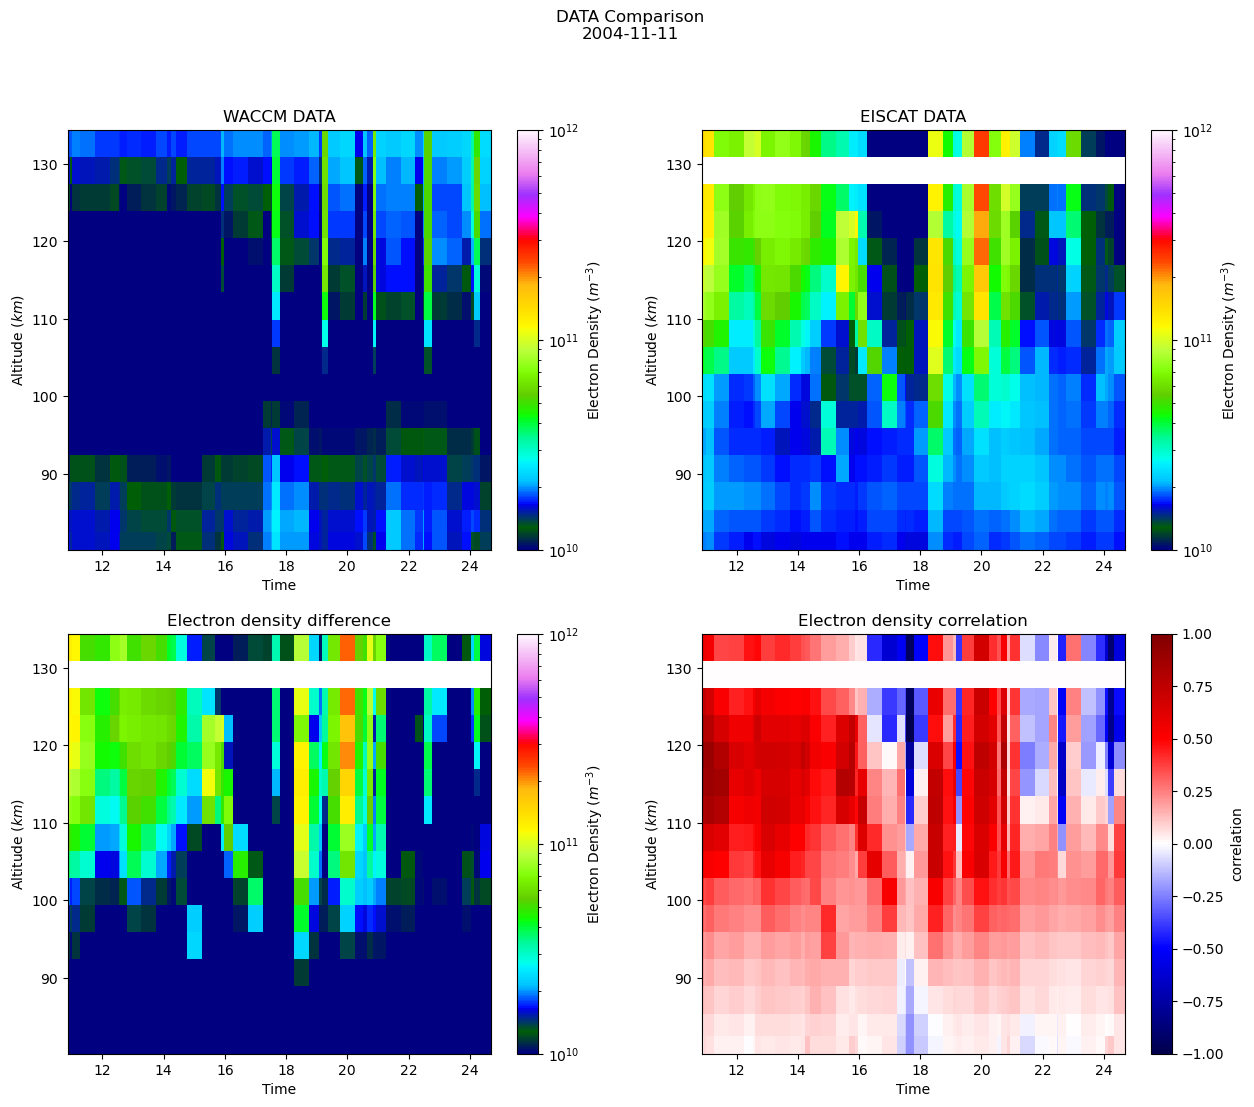

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

newHours = np.array([])

Ne_diff_WACCM = np.array([])
Ne_diff_EISCAT = np.array([])
H_diff_WACCM = np.array([])
H_diff_EISCAT = np.array([])
time_diff_WACCM = np.array([])
time_diff_EISCAT = np.array([])

i = 0
while hours[i] < max(Time_hours_minutes) and i < len(hours) - 1:
    if hours[i] > min(Time_hours_minutes):
        Ne_diff_WACCM = np.concatenate((Ne_diff_WACCM, Ne_convert(NeWACCM[i],P*100,T[i][lev_mask])))
        H_diff_WACCM = np.concatenate((H_diff_WACCM, H))
        time_diff_WACCM = np.concatenate((time_diff_WACCM, [hours[i]]))
    i += 1

newHours = hours[:i]

i = 0
while newHours[i] < min(Time_hours_minutes):
    i += 1

newHours = newHours[i:]

i = 0
for i in range(len(newHours)):
    t_mask = (Time_hours_minutes > newHours[i]) & (Time_hours_minutes < newHours[i] + 0.5)
    if sum(t_mask) != 0:
        time1 = Time_hours_minutes[t_mask]
        Ne1 = Ne[t_mask]
        h1 = h[t_mask]
        for j in range(len(H)):
            h_mask = ((h1 - H[j])**2 < 10)
            if sum(h_mask != 0):
                Ne2 = np.mean(Ne1[h_mask])
                Ne_diff_EISCAT = np.concatenate((Ne_diff_EISCAT, np.array([Ne2])))
                H_diff_EISCAT = np.concatenate((H_diff_EISCAT, [H[j]]))
                time_diff_EISCAT = np.concatenate((time_diff_EISCAT, [newHours[i]]))
            else:
                Ne_diff_EISCAT = np.concatenate((Ne_diff_EISCAT, np.array([0])))
                H_diff_EISCAT = np.concatenate((H_diff_EISCAT, [H[j]]))
                time_diff_EISCAT = np.concatenate((time_diff_EISCAT, [newHours[i]]))
    else:
        Ne_diff_EISCAT = np.concatenate((Ne_diff_EISCAT, np.repeat([0], len(H))))
        H_diff_EISCAT = np.concatenate((H_diff_EISCAT, H))
        time_diff_EISCAT = np.concatenate((time_diff_EISCAT, np.repeat(hours[i], len(H))))
        

density_grid_WACCM = Ne_diff_WACCM.reshape(len(time_diff_WACCM),len(np.unique(H_diff_WACCM))).T

sc1 = axs[0][0].pcolormesh(time_diff_WACCM,
                         np.unique(H_diff_WACCM)[::-1],
                         density_grid_WACCM,
                         cmap='gist_ncar',
                         norm = LogNorm(1e10, 1e12))

cbar = fig.colorbar(sc1, ax=axs[0][0])
cbar.set_label(r'Electron Density ($m^{-3}$)')
axs[0][0].set_ylabel(r'Altitude ($km$)')
axs[0][0].set_xlabel(r'Time')
axs[0][0].set_title('WACCM DATA')

density_grid_EISCAT = Ne_diff_EISCAT.reshape(len(time_diff_WACCM),len(np.unique(H_diff_EISCAT))).T

sc2 = axs[0][1].pcolormesh(time_diff_WACCM, 
                           np.unique(H_diff_EISCAT)[::-1], 
                           density_grid_EISCAT, 
                           cmap='gist_ncar',
                           norm = LogNorm(1e10, 1e12))
cbar = fig.colorbar(sc2, ax=axs[0][1])
cbar.set_label(r'Electron Density ($m^{-3}$)')
axs[0][1].set_ylabel(r'Altitude ($km$)')
axs[0][1].set_xlabel(r'Time')
axs[0][1].set_title('EISCAT DATA')
fig.suptitle('DATA Comparison' + '\n' + str(Date))

mask = Ne_diff_EISCAT != 0
time_diff = time_diff_WACCM
H_diff = H_diff_EISCAT

corr_factor = np.zeros(len(np.unique(H_diff))*len(time_diff))
corr_factor[mask] = (np.log10(Ne_diff_EISCAT[mask]) - np.log10(Ne_diff_WACCM[mask]))
min_value = min(corr_factor)
max_value = max(corr_factor)

new_corr_factor = []

i = 0
for value in corr_factor:
    if value < 0:
        new_corr_factor.append(corr_factor[i]/-min_value)
    elif value > 0:
        new_corr_factor.append(corr_factor[i]/max_value)
    else:
        new_corr_factor.append(0)
    i += 1

corr_factor = np.array(new_corr_factor)

abs_max = np.max(np.abs(corr_factor))

# Set the normalization range symmetrically around zero
norm = Normalize(vmin=-abs_max, vmax=abs_max)
diff_density = np.abs(Ne_diff_WACCM - Ne_diff_EISCAT)
diff_density[~mask] = 0
diff_density_grid = diff_density.reshape(len(time_diff),len(np.unique(H_diff))).T
corr_factor_grid = corr_factor.reshape(len(time_diff),len(np.unique(H_diff))).T

sc3 = axs[1][0].pcolormesh(time_diff, 
                           np.unique(H_diff)[::-1],
                           diff_density_grid,
                           cmap='gist_ncar', 
                           norm=LogNorm(vmin=10e9, vmax=10e11))

cbar = fig.colorbar(sc3, ax=axs[1][0])
cbar.set_label(r'Electron Density ($m^{-3}$)')
axs[1][0].set_ylabel(r'Altitude ($km$)')
axs[1][0].set_xlabel(r'Time')
axs[1][0].set_title('Electron density difference')

sc4 = axs[1][1].pcolormesh(time_diff, 
                           np.unique(H_diff)[::-1], 
                           corr_factor_grid,
                           cmap='seismic',
                           norm=norm)

cbar = fig.colorbar(sc4, ax=axs[1][1])
cbar.set_label('correlation')
axs[1][1].set_ylabel(r'Altitude ($km$)')
axs[1][1].set_xlabel(r'Time')
axs[1][1].set_title('Electron density correlation')

plt.show()